# Reverse Modeling of an Emission Spectrum using the MODIT Cross Section

Update: November 23rd; Septempber 3rd (2021) Hajime Kawahara

We try to fit an emission spectrum model to the mock data in which many methane lines exist. This situation mocks a T-type brown dwarf.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

Loading the mock data generated by XXX.

In [2]:
dat=pd.read_csv("spectrum_ch4.txt",delimiter=",",names=("wav","flux"))

Inject an additional Gaussian noise into the spectrum

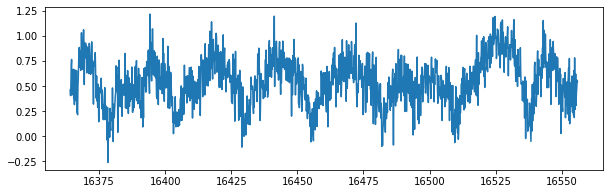

In [12]:
wavd=dat["wav"].values[30:-30]
flux=dat["flux"].values[30:-30]
nusd=jnp.array(1.e8/wavd[::-1]) #wavenumber
sigmain=0.15
norm=1.e-2
nflux=flux/norm+np.random.normal(0,sigmain,len(wavd))
plt.figure(figsize=(10,3))
plt.plot(wavd[::-1],nflux)


Let's set a model atmospheric layers, wavenumber range for the model, an instrument, 

In [24]:
from exojax.rt.rtransfer import pressure_layer,wavenumber_grid
from exojax.utils.constants import c
from exojax.utils.instfunc import resolution_to_gaussian_std

NP=100
Parr, dParr, k=pressure_layer(NP=NP)
Nx=5000
nus,wav,res=wavenumber_grid(np.min(wavd)-5.0,np.max(wavd)+5.0,Nx,unit="AA",xsmode="modit")

Rinst=100000. #instrumental spectral resolution
beta_inst=resolution_to_gaussian_std(Rinst)  #equivalent to beta=c/(2.0*np.sqrt(2.0*np.log(2.0))*R)

xsmode assumes ESLOG in wavenumber space: mode=modit


/home/kawahara/exojax/src/exojax/utils/grids.py:124: UserWarning: Resolution may be too small. R=407349.0039001706
  warnings.warn('Resolution may be too small. R=' + str(resolution),


Loading molecular database, CIA, and define some values.

In [14]:
from exojax.database import api , contdb
from exojax.database import molinfo 

mmw=2.33 #mean molecular weight

mdbCH4=api.MdbExomol('.database/CH4/12C-1H4/YT10to10/',nus,crit=1.e-30, Ttyp=300.)
molmassCH4=molinfo.molmass("CH4")

cdbH2H2=contdb.CdbCIA('.database/H2-H2_2011.cia',nus)
molmassH2=molinfo.molmass("H2")
mmrH2=0.74
vmrH2=(mmrH2*mmw/molmassH2) #VMR
Mp = 33.2 

Background atmosphere:  H2
Reading .database/CH4/12C-1H4/YT10to10/12C-1H4__YT10to10__06000-06100.trans.bz2
Reading .database/CH4/12C-1H4/YT10to10/12C-1H4__YT10to10__06100-06200.trans.bz2
.broad is used.
Broadening code level= a1
default broadening parameters are used for  12  J lower states in  29  states
H2-H2


Check the line strength of the lines..

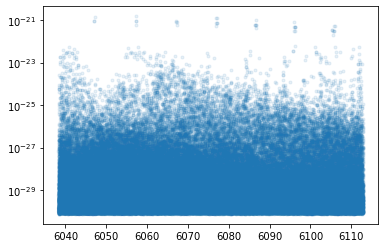

In [15]:
plt.plot(mdbCH4.nu_lines,mdbCH4.Sij0,".",alpha=0.1)
plt.yscale("log")

Define some arrays for the model.

In [16]:
#reference pressure for a T-P model                                             
Pref=1.0 #bar
ONEARR=np.ones_like(Parr)
ONEWAV=jnp.ones_like(nflux)

Initialize MODIT

In [17]:
from exojax.opacity import initspec
cnu,indexnu,R,pmarray=initspec.init_modit(mdbCH4.nu_lines,nus)

Do not confuse R with Rinst. R is the spectral resolution of the raw spectral model, which should be higher than Rinst, while Rinst is the instrumental spectral resolution.

In [18]:
Rinst, R

(100000.0, 407349.0039001706)

We need to set DIT grid matrix (DGM), but, a temperature profile varies during sampling. So we check max/min of profiles. setdgm_exomol can automatically set DGM based on the T-P model and given ranges.

In [23]:
# Precomputing gdm_ngammaL                                                                                              
from exojax.opacity.modit import setdgm_exomol
from jax import jit, vmap

fT = lambda T0,alpha: T0[:,None]*(Parr[None,:]/Pref)**alpha[:,None]
T0_test=np.array([200.0,500.0,200.0,500.0])
alpha_test=np.array([0.05,0.05,0.01,0.01])
resmodit=0.2
dgm_ngammaL=setdgm_exomol(mdbCH4,fT,Parr,R,molmassCH4,resmodit,T0_test,alpha_test)

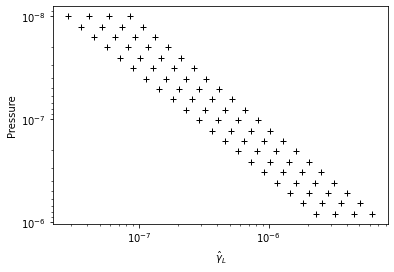

In [20]:
#show the DIT grids 
from exojax.plot.ditplot import plot_dgmn
plot_dgmn(Parr,dgm_ngammaL,None,0,20)

We here use numpyro as a PPL (probabilistic programming language).

In [21]:
from jax import random
import numpyro.distributions as dist
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

Then, construct the model, but, this is the most complex part of the retrieval. To support this process, exojax provides modit.exomol to get the line intensity, normalized widths.  Here the user-defined functino frun returns a spectral model. 

In [25]:
from exojax.opacity.modit import exomol,xsmatrix
from exojax.rt.rtransfer import dtauM, dtauCIA, rtrun
from exojax.rt import planck, response
from exojax.spec.response import ipgauss_sampling
from exojax.spec.spin_rotation import convolve_rigid_rotation
from exojax.utils.grids import velocity_grid
vsini_max = 100.0
vr_array = velocity_grid(res, vsini_max)


In [26]:
def frun(Tarr,MMR_CH4,Mp,Rp,u1,u2,RV,vsini):
    g=2478.57730044555*Mp/Rp**2
    SijM,ngammaLM,nsigmaDl=exomol(mdbCH4,Tarr,Parr,R,molmassCH4)
    xsm=xsmatrix(cnu,indexnu,R,pmarray,nsigmaDl,ngammaLM,SijM,nus,dgm_ngammaL)
    dtaum=dtauM(dParr,jnp.abs(xsm),MMR_CH4*ONEARR,molmassCH4,g)
    #CIA                                                                                                                
    dtaucH2H2=dtauCIA(nus,Tarr,Parr,dParr,vmrH2,vmrH2,mmw,g,cdbH2H2.nucia,cdbH2H2.tcia,cdbH2H2.logac)
    dtau=dtaum+dtaucH2H2
    sourcef = planck.piBarr(Tarr,nus)
    F0=rtrun(dtau,sourcef)/norm
    Frot = convolve_rigid_rotation(F0, vr_array, vsini, u1, u2)
    mu = ipgauss_sampling(nusd, nus, Frot, beta_inst, RV)
    return mu

Test plot using frun

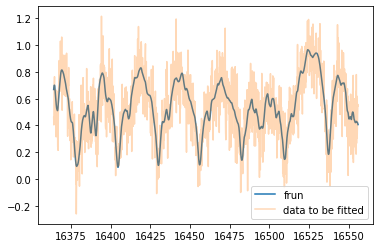

In [31]:
T0=400.0 #K                                                                                                        
Tarr = T0*(Parr/Pref)**0.03
mu=frun(Tarr,MMR_CH4=0.0058,Mp=33.5,Rp=0.88,u1=0.0,u2=0.0,RV=10.0,vsini=20.0)
plt.plot(wavd[::-1],mu,label="frun")
plt.plot(wavd[::-1],nflux,alpha=0.3,label="data to be fitted")
plt.legend()
plt.show()


Let's define the model for a HMC.

In [32]:
Mp=33.2
Rp=0.88
#we assume we know gravity here.

def model_c(y1):
    #Rp = numpyro.sample('Rp', dist.Uniform(0.87,0.89))
    RV = numpyro.sample('RV', dist.Uniform(5.0,15.1))
    MMR_CH4 = numpyro.sample('MMR_CH4', dist.Uniform(0.0,0.01))
    T0 = numpyro.sample('T0', dist.Uniform(350.0,450.0))
    alpha=numpyro.sample('alpha', dist.Uniform(0.02,0.04))
    vsini = numpyro.sample('vsini', dist.Uniform(15.0,25.0)) 
    sigma = numpyro.sample('sigma',dist.Exponential(1.0))
    #sigma = sigma*0.05
    u1=0.0
    u2=0.0                                                                                                 
    Tarr = T0*(Parr/Pref)**alpha  
    

    mu=frun(Tarr,MMR_CH4,Mp,Rp,u1,u2,RV,vsini)
    numpyro.sample("y1", dist.Normal(mu, sigma), obs=y1)

In [33]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 100, 200
#kernel = NUTS(model_c,forward_mode_differentiation=True,max_tree_depth=9) #52min
kernel = NUTS(model_c,max_tree_depth=9) #54min
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(rng_key_, y1=nflux)


sample: 100%|██████████| 300/300 [48:57<00:00,  9.79s/it, 63 steps of size 5.29e-02. acc. prob=0.91]  


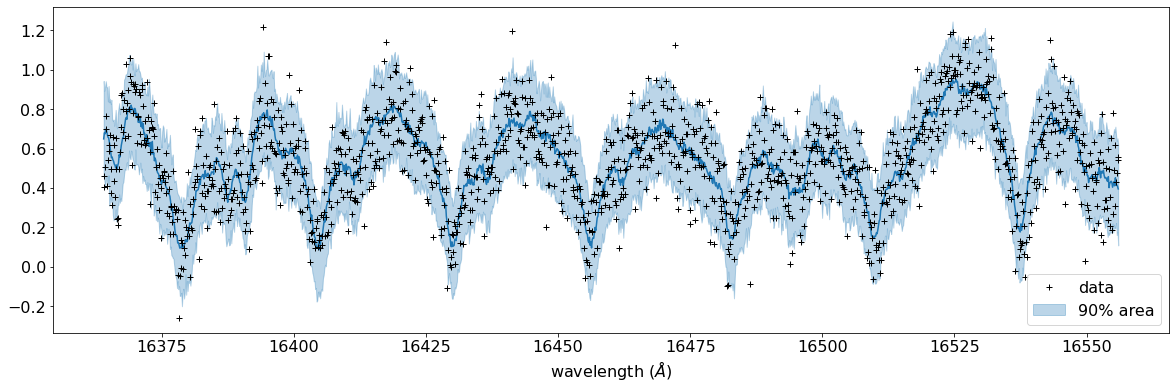

In [36]:
posterior_sample = mcmc.get_samples()
pred = Predictive(model_c,posterior_sample,return_sites=["y1"])
predictions = pred(rng_key_,y1=None)
median_mu1 = jnp.median(predictions["y1"],axis=0)
hpdi_mu1 = hpdi(predictions["y1"], 0.9)                                      
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,6.0))
ax.plot(wavd[::-1],median_mu1,color="C0")
ax.plot(wavd[::-1],nflux,"+",color="black",label="data")
ax.fill_between(wavd[::-1], hpdi_mu1[0], hpdi_mu1[1], alpha=0.3, interpolate=True,color="C0",label="90% area")
plt.xlabel("wavelength ($\AA$)",fontsize=16)
plt.legend(fontsize=16)
plt.tick_params(labelsize=16)

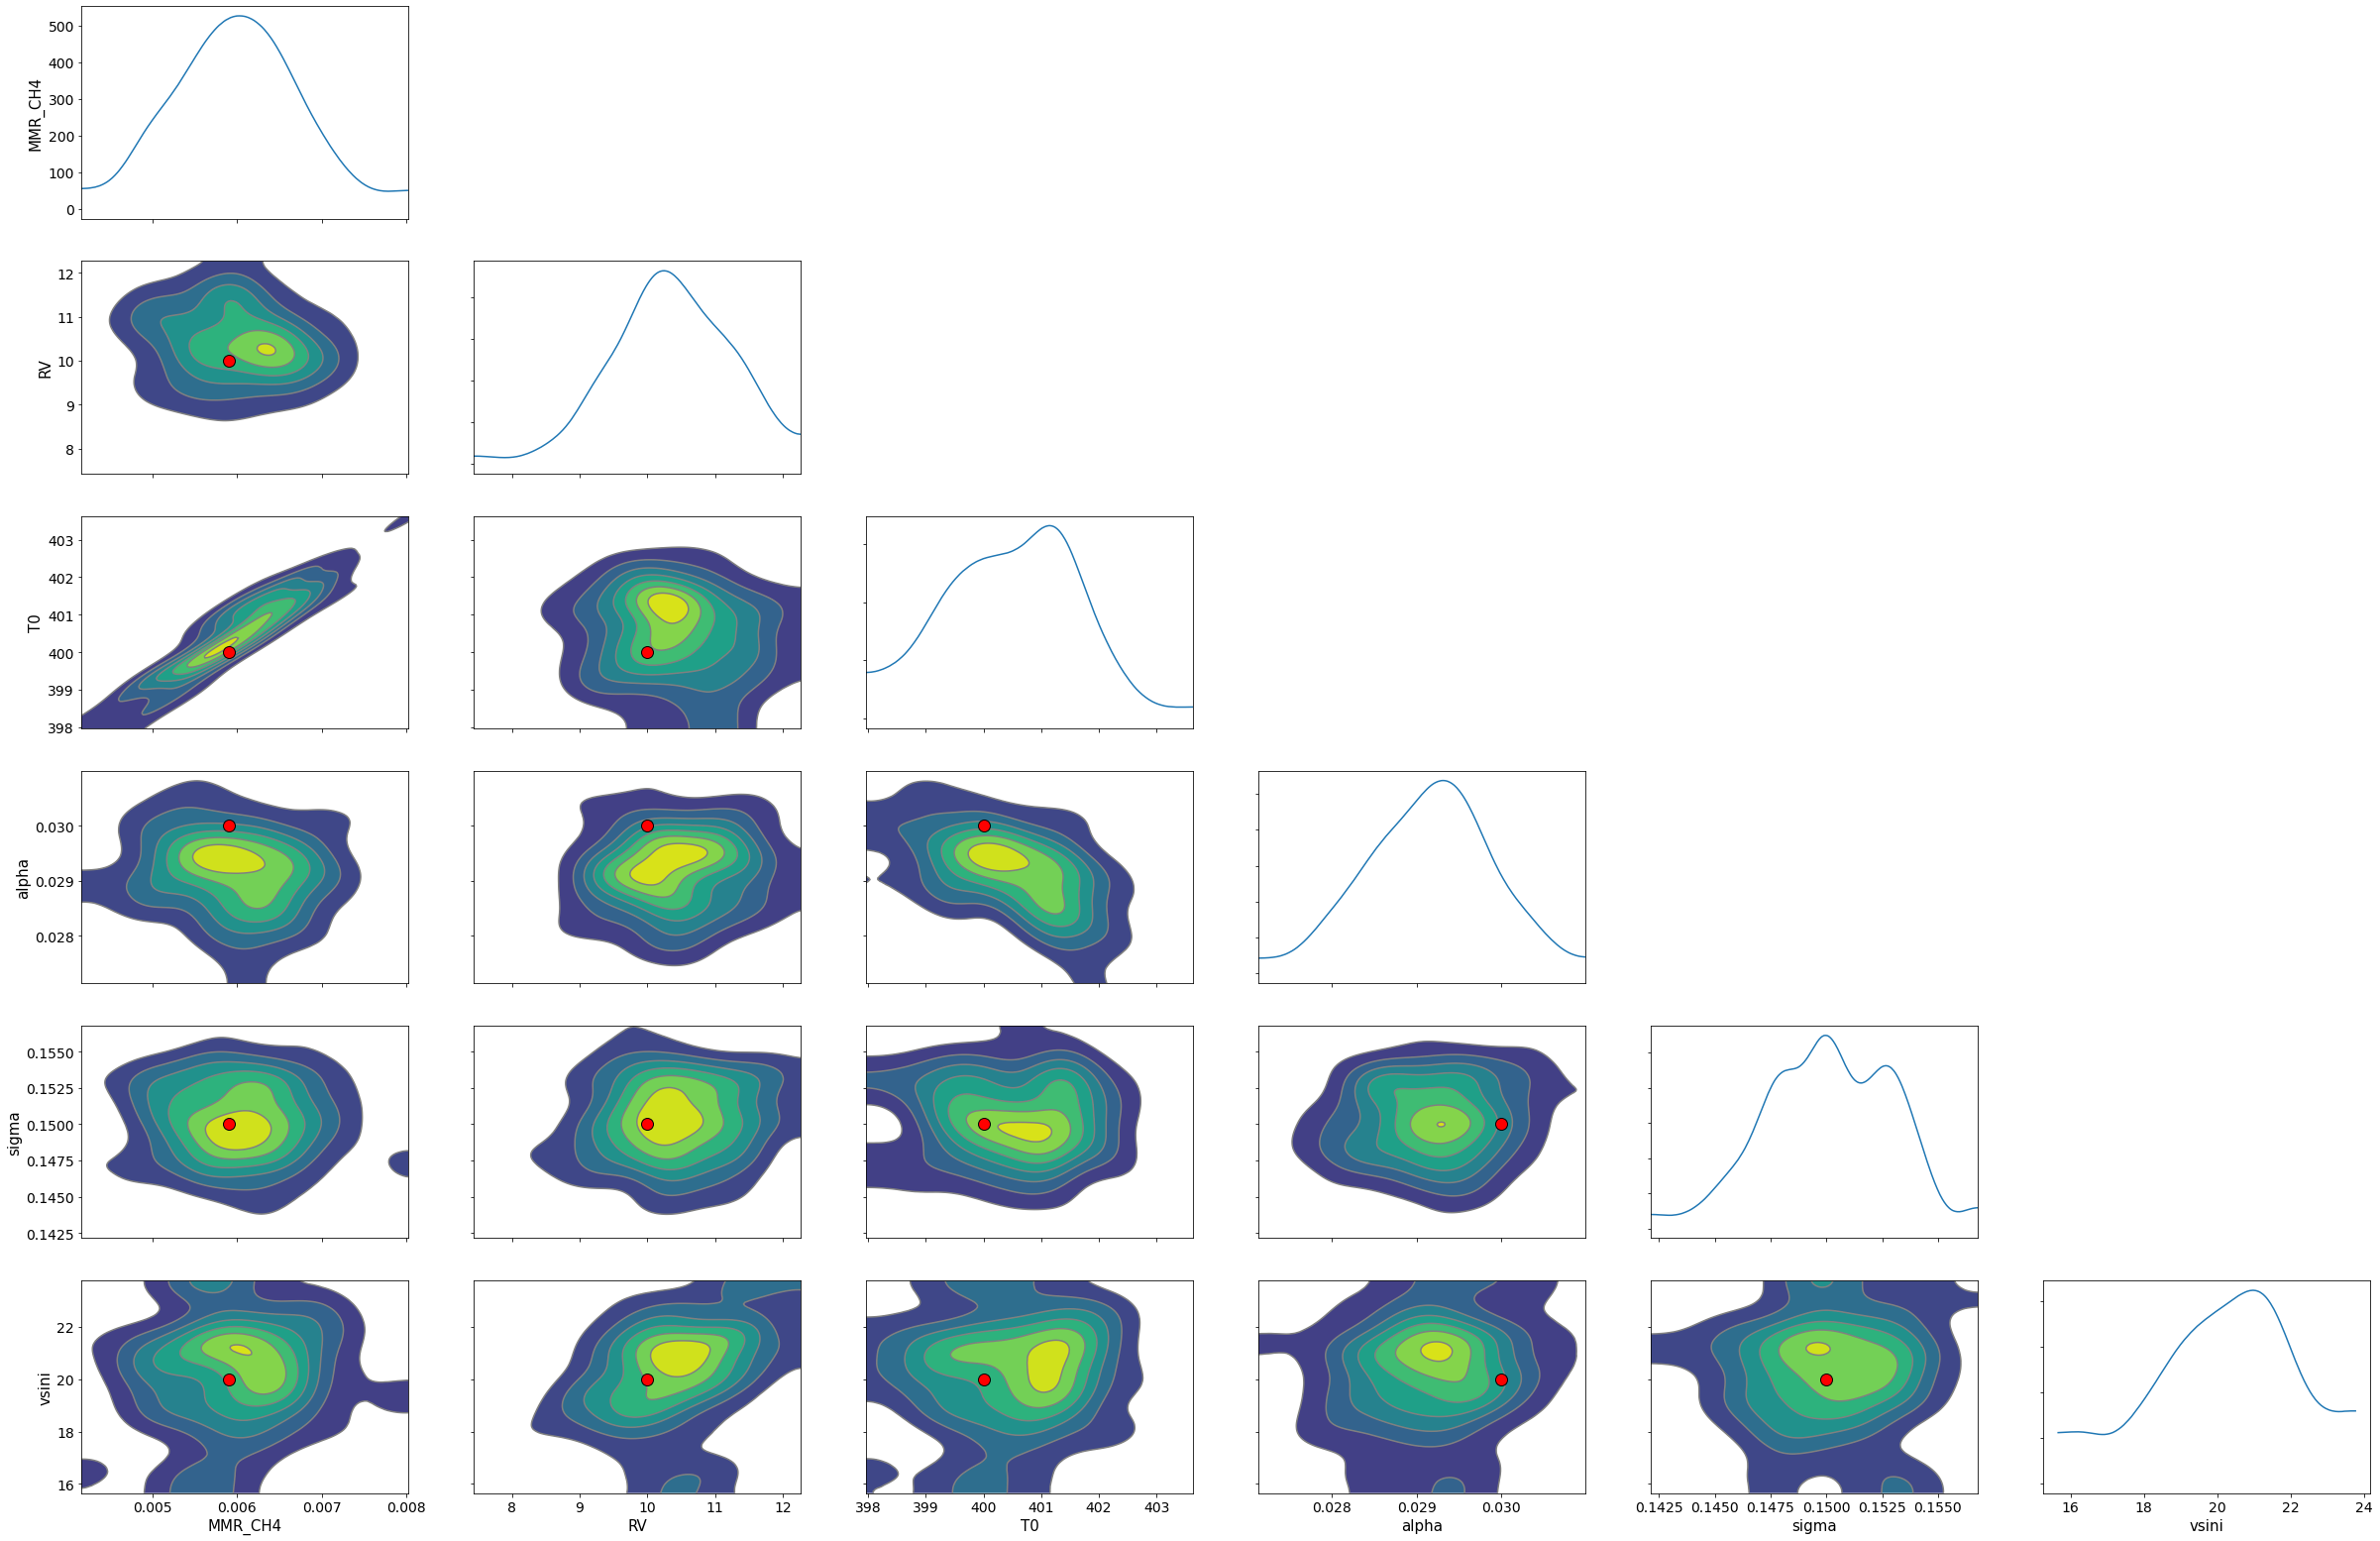

In [37]:
import arviz
refs={};refs["RV"]=10.0;refs["T0"]=400;refs["MMR_CH4"]=0.0059;refs["alpha"]=0.03;refs["vsini"]=20.0;refs["sigma"]=0.15;
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',divergences=False,marginals=True,
               reference_values=refs,reference_values_kwargs={'color':"red", "marker":"o", "markersize":12})
plt.show()